# Analyse adaptive CPG output

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import plotting
import numpy as np

/home/asude/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12328, receiver_port=12329)
model = dynapse.model

[0]:  Bus 3 Device 61 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 46 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 42 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 39 Dynapse1DevKit serial_number 00000007
[4]:  Bus 1 Device 44 Dynapse1DevKit serial_number 00000020
[5]:  Bus 1 Device 25 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12328
Receiver port: tcp://0.0.0.0:12329
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [38]:
chip_1 = 2
core_e1_1 = 0
core_e2_1 = 1
core_i_1 = 2

neuron_ids_E1_1 = np.arange(11,19)
neuron_ids_E2_1 = neuron_ids_E1_1 + neuron_ids_E1_1.size
neuron_ids_I1_1 = [3]
neuron_ids_I2_1 =[4]

# init a network generator
net = network.DynapseNetworkGenerator()

neurons_E1_1 = net.get_neurons(chip_1, core_e1_1, neuron_ids_E1_1)
neurons_I1_1 = net.get_neurons(chip_1, core_i_1, neuron_ids_I1_1)
neurons_E2_1 = net.get_neurons(chip_1, core_e2_1, neuron_ids_E2_1)
neurons_I2_1 = net.get_neurons(chip_1, core_i_1, neuron_ids_I2_1)

net.add_connections_all_to_all(neurons_E1_1, neurons_E1_1, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_E1_1, neurons_I1_1, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_all(neurons_I1_1, neurons_E1_1, network.SYNAPSE_GABA_B, weight=8)

net.add_connections_all_to_all(neurons_E2_1, neurons_E2_1, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_E2_1, neurons_I2_1, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_all(neurons_I2_1, neurons_E2_1, network.SYNAPSE_GABA_B, weight=8)

# coupling
net.add_connections_all_to_all(neurons_I1_1, neurons_I2_1, network.SYNAPSE_GABA_B)
net.add_connections_all_to_all(neurons_I2_1, neurons_I1_1, network.SYNAPSE_GABA_B)

# dynapse.monitor_neuron_network(neurons_E1_1, neurons_E2_1, neurons_I1_1, neurons_I2_1)

#################################################################################

chip_2 = 0
core_e1_2 = 0
core_e2_2 = 1
core_i_2 = 2

neuron_ids_E1_2 = np.arange(91,99)
neuron_ids_E2_2 = neuron_ids_E1_2 + neuron_ids_E1_2.size
neuron_ids_I1_2 = [10]
neuron_ids_I2_2 =[77]

# # init a network generator
# net = network.DynapseNetworkGenerator()

neurons_E1_2 = net.get_neurons(chip_2, core_e1_2, neuron_ids_E1_2)
neurons_I1_2 = net.get_neurons(chip_2, core_i_2, neuron_ids_I1_2)
neurons_E2_2 = net.get_neurons(chip_2, core_e2_2, neuron_ids_E2_2)
neurons_I2_2 = net.get_neurons(chip_2, core_i_2, neuron_ids_I2_2)

net.add_connections_all_to_all(neurons_E1_2, neurons_E1_2, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_E1_2, neurons_I1_2, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_all(neurons_I1_2, neurons_E1_2, network.SYNAPSE_GABA_B, weight=8)

net.add_connections_all_to_all(neurons_E2_2, neurons_E2_2, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_E2_2, neurons_I2_2, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_all(neurons_I2_2, neurons_E2_2, network.SYNAPSE_GABA_B, weight=8)

# coupling
net.add_connections_all_to_all(neurons_I1_2, neurons_I2_2, network.SYNAPSE_GABA_B)
net.add_connections_all_to_all(neurons_I2_2, neurons_I1_2, network.SYNAPSE_GABA_B)

## COUPLING OF CPGs
# net.add_connections_all_to_all(neurons_E1_1, neurons_E1_2, network.SYNAPSE_AMPA)
# net.add_connections_all_to_all(neurons_E1_2, neurons_E1_1, network.SYNAPSE_AMPA)

# net.add_connections_all_to_all(neurons_E2_1, neurons_E2_2, network.SYNAPSE_AMPA)
# net.add_connections_all_to_all(neurons_E2_2, neurons_E2_1, network.SYNAPSE_AMPA)

dynapse.monitor_neuron_network(neurons_E1_2, neurons_E2_2, neurons_I1_2, neurons_I2_2, neurons_E1_1, neurons_E2_1, neurons_I1_1, neurons_I2_1)

model.apply_configuration(net.get_config())

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


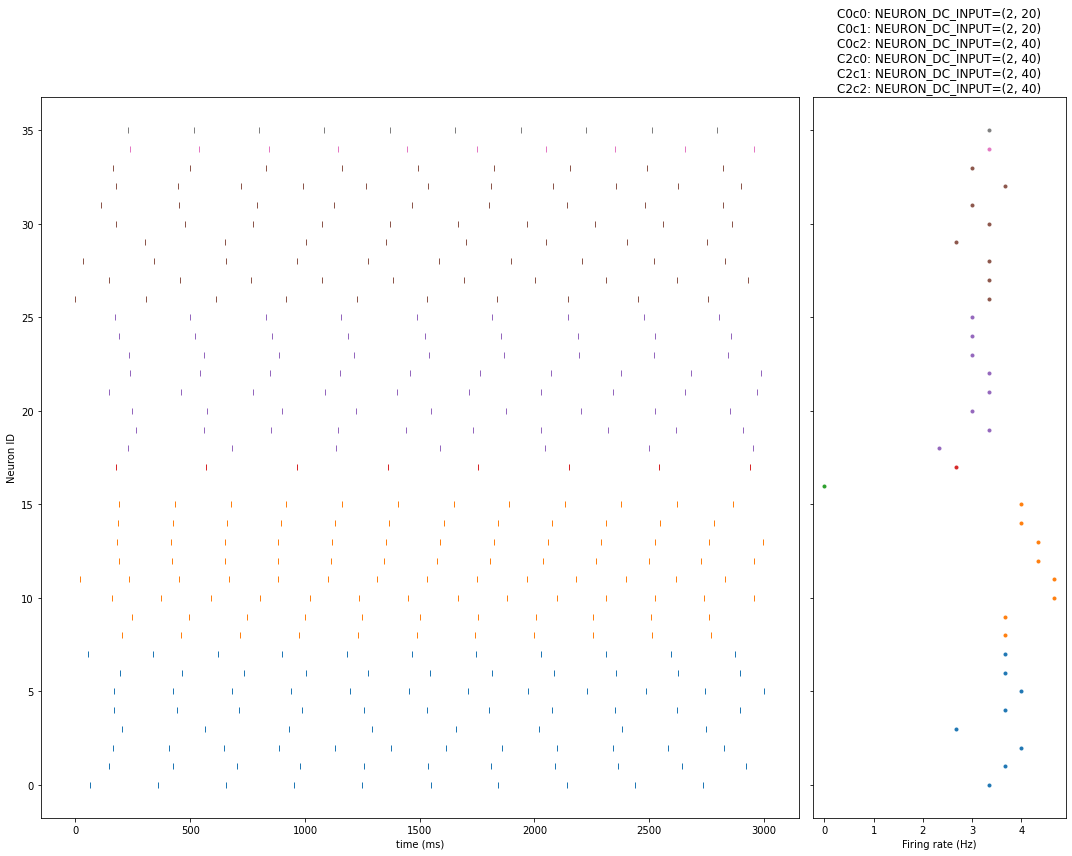

In [42]:






# set params
parameters.set_all_default_params(model)

# Chip1 core e1 parameters
# parameters.set_param(model, parameters.AMPA_WEIGHT, (7,40), chip_1, core_e1_1)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip_1, core_e1_1)
# parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip_1, core_e1_1)
# parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip_1, core_e1_1)

# chip1 core e2 parameters 
# parameters.set_param(model, parameters.AMPA_WEIGHT, (7,40), chip_1, core_e2_1)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip_1, core_e2_1)
# parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip_1, core_e2_1)
# parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip_1, core_e2_1)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip_1, core_i_1)

# Chip1 Core i parameters
# parameters.set_param(model, parameters.AMPA_WEIGHT, (5,70), chip_1, core_i_1)
# parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip_1, core_i_1)
# parameters.set_param(model, parameters.GABA_B_LEAKAGE, (2,30), chip_1, core_i_1)
# parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip_1, core_i_1)

####################################################################################

# parameters.set_param(model, parameters.AMPA_WEIGHT, (6,70), chip_2, core_e1_2)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,20), chip_2, core_e1_2)
# parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip_2, core_e1_2)
# parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip_2, core_e1_2)

# Chip2 core e2 parameters 
# parameters.set_param(model, parameters.AMPA_WEIGHT, (6,70), chip_2, core_e2_2)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,20), chip_2, core_e2_2)
# parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip_2, core_e2_2)
# parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip_2, core_e2_2)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip_2, core_i_2)


# Chip2 Core i parameters
# parameters.set_param(model, parameters.AMPA_WEIGHT, (6,50), chip_2, core_i_2) ### change
# parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip_2, core_i_2)
# parameters.set_param(model, parameters.GABA_B_LEAKAGE, (2,30), chip_2, core_i_2) ### change
# parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip_2, core_i_2)

dynapse.start_graph()
spikes = dynapse.run_simulation(3)

# plotting.plot_spikes(dynapse, spikes)
plotting.plot_spikes_and_frequencies(dynapse, spikes, figsize=(15,12))


In [40]:
# TOP CPG
I1_spikes = plotting.extract_spikes_group(plotting.convert_spikes_to_array(spikes), dynapse.monitored_neuron_groups[6])
I2_spikes = plotting.extract_spikes_group(plotting.convert_spikes_to_array(spikes), dynapse.monitored_neuron_groups[7])
T1 = np.mean(np.diff(I1_spikes[:,0]))
T2 = np.mean(np.diff(I2_spikes[:,0]))
print(f'E1 firing rate: {1000/T1:.4f} Hz')
print(f'E2 firing rate: {1000/T2:.4f} Hz')
print(f'phase diff = {np.mean(I1_spikes[:min(I1_spikes.shape[0],I2_spikes.shape[0]),0]-I2_spikes[:min(I1_spikes.shape[0],I2_spikes.shape[0]),0]) / (T1+T2)*2 * 360} deg')
# BOTTOM CPG
I1_spikes = plotting.extract_spikes_group(plotting.convert_spikes_to_array(spikes), dynapse.monitored_neuron_groups[2])
I2_spikes = plotting.extract_spikes_group(plotting.convert_spikes_to_array(spikes), dynapse.monitored_neuron_groups[3])
T1 = np.mean(np.diff(I1_spikes[:,0]))
T2 = np.mean(np.diff(I2_spikes[:,0]))
print(f'E1 firing rate: {1000/T1:.4f} Hz')
print(f'E2 firing rate: {1000/T2:.4f} Hz')
print(f'phase diff = {np.mean(I1_spikes[:min(I1_spikes.shape[0],I2_spikes.shape[0]),0]-I2_spikes[:min(I1_spikes.shape[0],I2_spikes.shape[0]),0]) / (T1+T2)*2 * 360} deg')


E1 firing rate: 3.3116 Hz
E2 firing rate: 3.5073 Hz
phase diff = 300.3181953389077 deg
E1 firing rate: nan Hz
E2 firing rate: 2.5250 Hz
phase diff = nan deg
/home/asude/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/asude/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
spikes_group1 = plotting.extract_spikes_group(plotting.convert_spikes_to_array(spikes), neuron_ids_I1_2)
spikes_group2 = plotting.extract_spikes_group(plotting.convert_spikes_to_array(spikes), neuron_ids_I2_2)
print(dynapse.monitored_neuron_groups[2])
print(neuron_ids_I1_2)
print(spikes_group1)
print(I1_spikes)

T1 = np.mean(np.diff(spikes_group1[:,0]))
T2 = np.mean(np.diff(spikes_group2[:,0]))

print(f'Neuron {neuron_ids_I1_2[0]} firing rate: {1000/T1:.4f} Hz')
print(f'Neuron {neuron_ids_I2_2[0]}  firing rate: {1000/T2:.4f} Hz')
print(f'phase diff = {np.mean(spikes_group1[:min(spikes_group1.shape[0],spikes_group2.shape[0]),0]-spikes_group2[:min(spikes_group1.shape[0],spikes_group2.shape[0]),0]) / (T1+T2)*2 *      360} deg')


[522]
[10]
[]
[]
Neuron 10 firing rate: nan Hz
Neuron 77  firing rate: nan Hz
phase diff = nan deg
